## A Comprehensive Look at the Empirical Performance of Equity Premium Prediction
##### Goyal and Welch(2008)  

## 文章回顾
**上学期第八周论文解读内容*

### - 研究问题  
    前人研究过的众多线性回归模型是否能在样本内和样本外稳定有效预测股市整体收益？
### - 研究方法  
    线性回归：样本内预测 + 样本外预测 
    样本内预测：在全部样本期回归得到参数（预测时会用到未来数据）
    样本外预测：在t期仅用前t-1期数据回归得到参数（预测时不用到未来数据）
### - 变量数据   
    http://www.hec.unil.ch/agoyal/docs/PredictorData.xls
    因变量：市场整体收益率
    自变量：15个单变量 + kitchen sink + model selection
    衡量指标：
        对样本内预测： 调整后的R2
        对样本外预测：（如下图）其中，MSEa为线性预测模型均方误差，MSEn为以历史均值为估计方法的均方误差

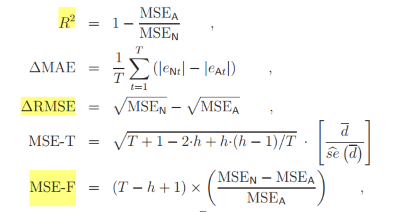

### - 研究结论
    没有任何模型具有稳定的预测能力

## 实证结果
** 主要展示和实现表1结果*
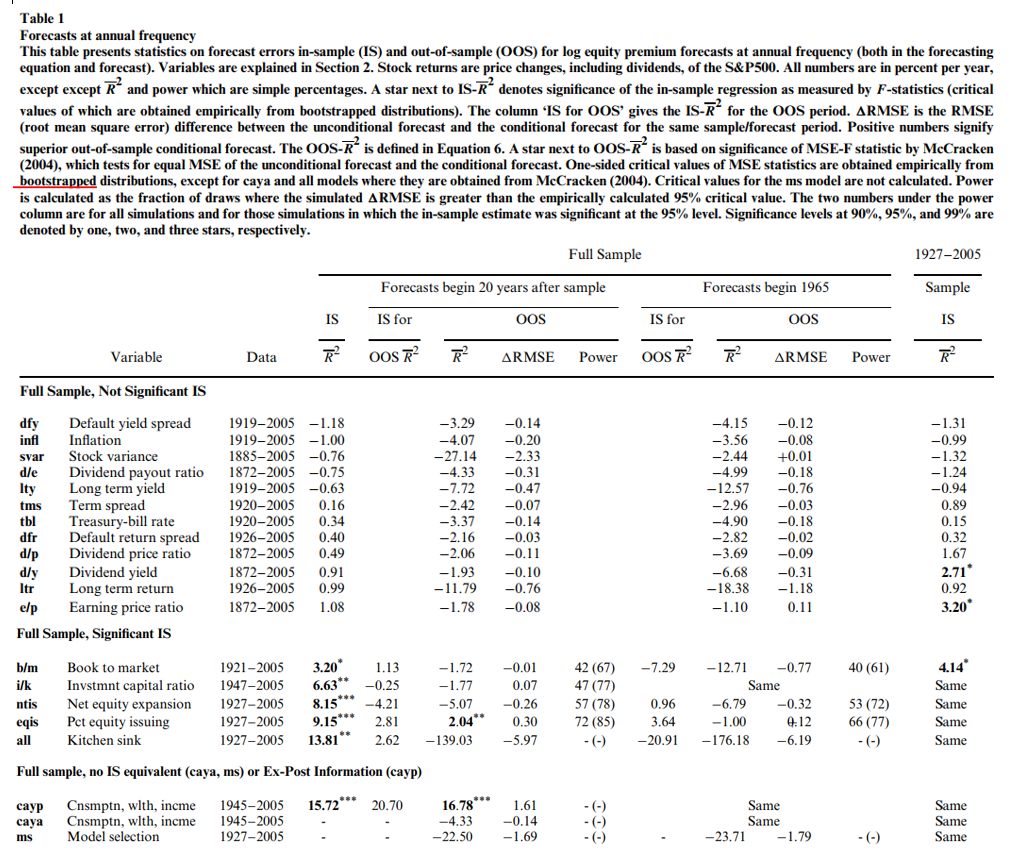

##### 说明：
- 注意有多种不同预测区间
- 除单变量外的模型：  
   
    - all: kitchen sink，即所有单变量组合的多变量回归             
    - ms: model selection （只对OOS有），即在第t期，根据前t-1期共```2^15 = 32768```个模型中表现最好的模型，衡量标准是累计平方误差    
    （ms非常耗时，来不及算了🙁，这里只展示code）      
    - caya: 无现成数据，方法类似    

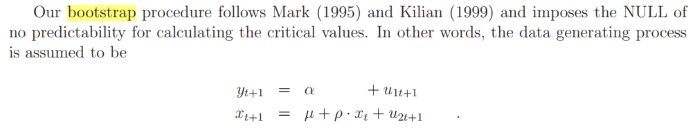   

- 统计检验：bootstrap构造临界值   

   - IS预测检验： measured by F-statistics (critical values of which are obtained empirically from bootstrapped distributions)
      1. 假设变量间没有预测关系，按上述模型回归得到残差序列和参数
      2. bootstrap残差，构造新的x、y序列
      3. 用新的序列进行样本内回归，计算回归的F值 ```F-stat = (SSR/k)/(SSE/(n-k-1))```   
      4. 重复上述步骤10000次，得到F值分布，取90th、95th、99th分位数为临界值
   - OOS预测检验： based on significance of MSE-F statistic
      
      - 和IS方法类似，不同在于构造新序列后，进行样本外回归，计算MSE-F值得到分布

- 样本外预测的power计算（存疑）
    
    calculated as the fraction of draws where the simulated RMSE is greater than the empirically calculated 95% critical value
       
    1. 按上面相同的方法得到零假设下RMSE的分布，计算95th分位数
    2. 以类似上述bootstrap的方式得到线性模型的RMSE分布（如下图式子）
    3. 计算10000个RMSE中大于第1步得到的临界值的比例，即为power

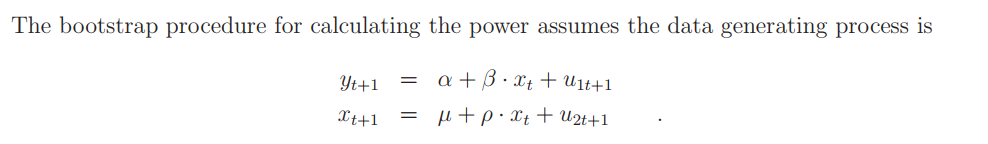

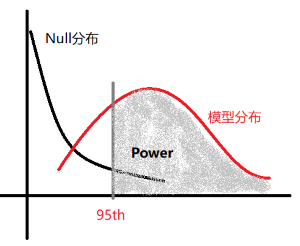

## 代码实现

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import random
from itertools import product
os.chdir('C:/Users/longzhen/Desktop/组会/GW2008_replication')

### 1. 变量构造


In [2]:
raw_data = pd.read_excel("originaldata_annual.xlsx", index_col=0)
def cons_var():
    temp = pd.DataFrame({
        "ret": np.log((raw_data.Index + raw_data.D12) / raw_data.Index.shift(1)) - np.log(raw_data.Rfree + 1),#注意收益率构造
        "dfy": raw_data.BAA - raw_data.AAA,
        "infl": raw_data.infl,
        "svar": raw_data.svar,
        "de": np.log(raw_data.D12) - np.log(raw_data.E12),
        'lty': raw_data.lty,
        "tms": raw_data.lty - raw_data.tbl,
        "tbl": raw_data.tbl,
        "dfr": raw_data.corpr - raw_data.ltr,
        "dp": np.log(raw_data.D12) - np.log(raw_data.Index),
        "dy": np.log(raw_data.D12) - np.log(raw_data.Index.shift(1)),
        "ltr": raw_data.ltr,
        "ep": np.log(raw_data.E12) - np.log(raw_data.Index),
        "bm": raw_data["b/m"],
        'ik': raw_data.ik,
        "ntis": raw_data.ntis,
        'eqis': raw_data.eqis,
#        'csp': raw_data.csp,  年度数据中没有csp
        'cay': raw_data.cay
    })

    return temp
a_data = cons_var()   
# a_data.to_excel("annually_data.xlsx")

In [3]:
a_data.head()

,ret,dfy,infl,svar,de,lty,tms,tbl,dfr,dp,dy,ltr,ep,bm,ik,ntis,eqis,cay
yyyy,,,,,,,,,,,,,,,,,,
1871,NaN,NaN,NaN,NaN,-0.430783,NaN,NaN,NaN,NaN,-2.903111,NaN,NaN,-2.472328,NaN,NaN,NaN,NaN,NaN
1872,0.055359,NaN,NaN,NaN,-0.360003,NaN,NaN,NaN,NaN,-2.827314,-2.760010,NaN,-2.467311,NaN,NaN,NaN,NaN,NaN
1873,-0.148267,NaN,NaN,NaN,-0.332134,NaN,NaN,NaN,NaN,-2.594802,-2.732003,NaN,-2.262668,NaN,NaN,NaN,NaN,NaN
1874,0.049551,NaN,NaN,NaN,-0.332134,NaN,NaN,NaN,NaN,-2.621590,-2.594802,NaN,-2.289456,NaN,NaN,NaN,NaN,NaN
1875,-0.014645,NaN,NaN,NaN,-0.182322,NaN,NaN,NaN,NaN,-2.678736,-2.716900,NaN,-2.496414,NaN,NaN,NaN,NaN,NaN


### 2. 样本内预测

In [4]:
#a_data = pd.read_excel('annually_data.xlsx',index_col = 0)
def samp(var, samp_period):
    '''
    按照不同的样本区间取出x,y (年度)
    full: 完整样本区间
    20y-: 变量可得20年后开始作为预测期
    1965-: 从1965年作为预测期
    1927-: 从1927年作为样本期
    '''
    x = a_data[var]
    y = a_data.ret
    start = x.dropna().index[0]
    if samp_period == 'full':
        x = x.loc[start:][:-1]
        y = y.loc[(start+1):]
    elif samp_period == '20y-':
        x = x.loc[(start+19):][:-1]
        y = y.loc[(start+20):]
    elif samp_period == '1965-':
        x = x.loc[1965:][:-1]
        y = y.loc[(1965+1):]
    else:  # 1927-
        if start >= 1927:
            return pd.Series([np.nan]), pd.Series([np.nan])
        else:
            x = x.loc[1927:][:-1]
            y = y.loc[(1927+1):]
    return y,x  
def IS(var, samp_period):
    '''
    样本内回归调整后R2  (年度，including dividends)
    input:
    var: str, 自变量名称
    samp_period: str, 回归的样本区间
    output:
    adjusted R2
    bootstrap F-statistics
    '''
    y, x = samp(var, samp_period)# 按照不同的样本区间取出x,y
    if np.isnan(x.iloc[0]):
        isR2 = 'same'
    else:
        result = sm.OLS(y.tolist(), sm.add_constant(x.tolist())).fit()  #拟合
        isR2 = result.rsquared_adj
    return isR2
variables = a_data.columns[1:]  # 去掉ret因变量
table1 = pd.DataFrame(index = variables, columns = ['ISR2','ISR2_20','OOSR2_20',
                                                    'rmse_20','power_20','ISR2_65',
                                                    'OOSR2_65','rmse_65','power_65',
                                                    'ISR2_27'])
for v in variables:
    table1.loc[v].ISR2 = IS(v,'full') * 100
    table1.loc[v].ISR2_20 = IS(v,'20y-')* 100
    table1.loc[v].ISR2_65 = IS(v,'1965-')* 100
    if IS(v,'1927-') != 'same':
        table1.loc[v].ISR2_27 = IS(v,'1927-')* 100
    else:
        table1.loc[v].ISR2_27 = 'same'

# kitchen sink
data_ks = a_data.drop(['ik','cay'],axis = 1).dropna()  # 1927-2005，从1927年开始有所有单变量数据
table1 = table1.T
table1['all'] = np.nan
table1 = table1.T
result = sm.OLS(data_ks.ret[1:21].tolist(), sm.add_constant(data_ks.iloc[:20,1:])).fit()
table1.loc['all'].ISR2 = result.rsquared_adj * 100
result = sm.OLS(data_ks.ret[21:].tolist(), sm.add_constant(data_ks.iloc[20:-1,1:])).fit()
table1.loc['all'].ISR2_20 = result.rsquared_adj * 100
result = sm.OLS(data_ks.ret[39:].tolist(), sm.add_constant(data_ks.iloc[38:-1,1:])).fit()
table1.loc['all'].ISR2_65 = result.rsquared_adj * 100
table1.loc['all'].ISR2_27 = 'same'

In [5]:
table1

,ISR2,ISR2_20,OOSR2_20,rmse_20,power_20,ISR2_65,OOSR2_65,rmse_65,power_65,ISR2_27
dfy,-1.18079,-1.53826,NaN,NaN,NaN,0.768991,NaN,NaN,NaN,-1.30528
infl,-0.937314,-0.352295,NaN,NaN,NaN,-2.6234,NaN,NaN,NaN,-0.990394
svar,-0.758608,-0.987625,NaN,NaN,NaN,-1.56812,NaN,NaN,NaN,-1.3156
de,-0.737887,-0.730801,NaN,NaN,NaN,-2.57604,NaN,NaN,NaN,-1.23286
lty,-0.625367,-0.242178,NaN,NaN,NaN,-1.26701,NaN,NaN,NaN,-0.93955
tms,0.159454,0.389201,NaN,NaN,NaN,2.14839,NaN,NaN,NaN,0.888256
tbl,0.342755,1.53981,NaN,NaN,NaN,-2.45942,NaN,NaN,NaN,0.152003
dfr,0.400913,0.468234,NaN,NaN,NaN,0.298054,NaN,NaN,NaN,0.316658
dp,0.488088,1.60682,NaN,NaN,NaN,0.12152,NaN,NaN,NaN,1.65553
dy,0.896986,1.858,NaN,NaN,NaN,0.204671,NaN,NaN,NaN,2.69224


- 结果对比:
   
   - 第一列全区间、最后一列1927年后的样本内回归几乎相同（除all）-> 说明变量构造和样本内回归方法问题不大(?)
   - 但中间两列IS for OOS 相差较大
- IS for OOS：
   
   - The column ‘IS for OOS’ gives the IS-R2 for the OOS period. It  shows how dependent variables' performance is on the first 20 years of the sample. 

### 3. 样本外预测

In [6]:
def histmean(data):  # prevailing mean estimation
    premean = pd.Series(index = data.index)
    for i in data.index:
        premean.loc[i] = data.loc[:i-1].mean()
    return premean
premean = histmean(a_data.ret)

def OOS(var):
    '''
    样本外回归预测序列
    '''
    x = a_data[var]
    y = a_data.ret
    start = x.dropna().index[0]
    pred = pd.Series(index = a_data.index)
    for i in range(start+20, 2005):# 样本外预测区间 最多是数据可得第20期开始
        x_reg = x.loc[start:i-1]  # expanding forecast window
        y_reg = y.loc[start+1:i] 
        x_test = a_data[var].loc[i]  # 用第i期预测第i+1期
        result = sm.OLS(y_reg.tolist(), sm.add_constant(x_reg.tolist())).fit()  #拟合
        pred.loc[i+1] = result.predict([1, x_test])[0]  #预测
    return pred

OOSpred = pd.DataFrame(index = a_data.index, columns = variables) # 保存单变量的样本外预测序列
for v in variables:
    OOSpred[v] = OOS(v)

# 加入样本外 all（kitchen sink）
OOSpred['all'] = np.nan
for i in range(1947,2005):
    result = sm.OLS(data_ks.iloc[1:i-1926,0].tolist(), sm.add_constant(data_ks.iloc[:i-1927,1:])).fit()
    OOSpred['all'].loc[i+1] = result.predict([1] + data_ks.iloc[i-1927,1:].tolist())[0]

### 4. ms模型构造

In [ ]:
# 计算量太大 只展示code
OOSpred['ms_20'] = np.nan
OOSpred['ms_65'] = np.nan

def varselect(data, samp_period):
    '''
    对每一期的模型做一次变量筛选，minimum cumulative squared errors为标准
    返回筛选过后的自变量
    '''
    a = [np.nan,1]
    loop_val = [a]*15  # 15个自变量
    pro = []
    for i in product(*loop_val):
        pro.append(i)
    pro = pro[1:]   # 全0的一组不要，函数中至少要有一个自变量
    optx = pd.DataFrame()
    optcse = 999
    for j in range(len(pro)):
        X = np.array(pro[j])*data.iloc[:-1,1:] 
        X = X.dropna(axis = 1)
        y = data.iloc[1:,0]
        end = y.index[-1]
        if samp_period == '20y-':
            start = 1947
        if samp_period == '1965-':
            start = 1965
        r = y.loc[start:end]
        pred = []
        for t in range(start,end+1):
            x_reg = X.loc[:t-1]  # expanding forecast window，X要比y滞后一期
            y_reg = y.loc[1:t] 
            result = sm.OLS(y_reg.tolist(), sm.add_constant(x_reg)).fit()  #拟合
            pred.append(result.predict([1]+ (np.array(pro[j])*data.loc[t][1:]).dropna().tolist())[0])
        cse = ((r-pred)**2).sum()
        if cse < optcse:
            optx = X
            optcse = cse
    return optx

for i in range(1927,2005): 
    msX = varselect(data_ks.loc[:i],'20y-')# x 1927-1946, y 1928-1947
    result = sm.OLS(data_ks.iloc[1:i-1926,0].tolist(), sm.add_constant(msX)).fit()
    OOSpred['ms_20'].loc[i+1] = result.predict([1] + data_ks[msX.columns].iloc[i-1926,:].tolist())[0]
for i in range(1965,2005):
    msX = varselect(data_ks.loc[:i],'1965-')# x 1927-1946, y 1928-1947
    result = sm.OLS(data_ks.iloc[1:i-1926,0].tolist(), sm.add_constant(msX)).fit()
    OOSpred['ms_65'].loc[i+1] = result.predict([1] + data_ks[msX.columns].iloc[i-1926,:].tolist())[0]

In [7]:
OOSpred.tail()

,dfy,infl,svar,de,lty,tms,tbl,dfr,dp,dy,ltr,ep,bm,ik,ntis,eqis,cay,all
yyyy,,,,,,,,,,,,,,,,,,
2001,0.066598,0.065268,0.057976,0.063768,0.065066,0.040437,0.056273,0.143094,0.002401,-0.027892,0.121011,0.013610,0.008037,-0.004251,0.127903,0.105192,0.012980,0.110740
2002,0.064001,0.065811,0.055116,0.048939,0.061461,0.128910,0.086423,0.028432,-0.008301,-0.043348,0.056957,-0.029120,-0.004572,0.061244,0.076787,0.134015,0.066260,-0.031646
2003,0.059966,0.060449,0.053996,0.047224,0.062063,0.097719,0.083464,0.070205,-0.009479,-0.056474,0.093390,-0.021314,0.009207,0.101352,0.041195,0.124911,0.075823,0.008639
2004,0.061589,0.063264,0.051876,0.053228,0.062600,0.114549,0.089099,0.029795,-0.006704,-0.007014,0.045042,0.014362,0.003959,0.098464,0.090566,0.133892,-0.001459,0.099417
2005,0.061388,0.061458,0.049855,0.055212,0.064525,0.086642,0.079025,0.062594,-0.000076,-0.010348,0.069457,0.022459,0.013753,0.083880,0.079412,0.129088,-0.009133,0.103115


In [8]:
def mse(y,pred):
    return ((y-pred)**2).mean()

def OOS_stat(var,samp_period):
    '''
    同时算两种预测区间的OOSR2和rmse
    '''
    start = OOSpred[var].dropna().index[0]
    if samp_period == '20y-':
        OOSstart = start+21
    else:
        OOSstart = 1965
    r = a_data.ret.loc[OOSstart:]
    MSEa = mse(r, OOSpred[var].loc[OOSstart:])
    MSEn = mse(r, premean.loc[OOSstart:])
    OOS_R2 = 1 - MSEa/MSEn
    RMSE = np.sqrt(MSEn) - np.sqrt(MSEa)
    return OOS_R2, RMSE

for v in OOSpred.columns:
    table1.loc[v].OOSR2_20 = OOS_stat(v,'20y-')[0] *100
    table1.loc[v].rmse_20 = OOS_stat(v,'20y-')[1] *100
    table1.loc[v].OOSR2_65 = OOS_stat(v,'1965-')[0] *100
    table1.loc[v].rmse_65 = OOS_stat(v,'1965-')[1] *100
    

In [9]:
table1

,ISR2,ISR2_20,OOSR2_20,rmse_20,power_20,ISR2_65,OOSR2_65,rmse_65,power_65,ISR2_27
dfy,-1.18079,-1.53826,-4.71302,-0.359808,NaN,0.768991,-5.65617,-0.435315,NaN,-1.30528
infl,-0.937314,-0.352295,-2.01111,-0.156198,NaN,-2.6234,-3.78503,-0.292626,NaN,-0.990394
svar,-0.758608,-0.987625,-33.5631,-2.9986,NaN,-1.56812,-0.455085,-0.0354728,NaN,-1.3156
de,-0.737887,-0.730801,-2.52317,-0.23857,NaN,-2.57604,-2.36713,-0.183641,NaN,-1.23286
lty,-0.625367,-0.242178,-13.0155,-0.974485,NaN,-1.26701,-14.1963,-1.07107,NaN,-0.93955
tms,0.159454,0.389201,-6.32159,-0.480163,NaN,2.14839,-5.92213,-0.455494,NaN,0.888256
tbl,0.342755,1.53981,-7.96473,-0.602615,NaN,-2.45942,-7.91372,-0.605799,NaN,0.152003
dfr,0.400913,0.468234,-3.5088,-0.273775,NaN,0.298054,-4.30511,-0.332414,NaN,0.316658
dp,0.488088,1.60682,-0.591022,-0.0561496,NaN,0.12152,-1.1353,-0.0883445,NaN,1.65553
dy,0.896986,1.858,-0.71243,-0.0677529,NaN,0.204671,-4.06188,-0.313818,NaN,2.69224


- 结果对比
   
   - OOS R2基本都不一样，rmse有约一半变量一样

### 5. 构造临界值

In [ ]:
random.seed(0)
def OOS_2mse(var,yboot,xboot,samp_period):
    premean = histmean(yboot).dropna()
    if samp_period == '20y-':
        start = yboot.index[0] + 20
    else:
        start = 1965
    pred = pd.Series(index = range(start,2005))
    for i in pred.index :# 样本外预测区间 
        x_reg = xboot.loc[:i-1]  # expanding forecast window
        y_reg = yboot.loc[:i]
        x_test = xboot.loc[i]  # 用0~i期预测第i+1期
        result = sm.OLS(y_reg.tolist(), sm.add_constant(x_reg.tolist())).fit()  #拟合
        pred.loc[i+1] = result.predict([1, x_test])[0]  #预测
    r = yboot.loc[pred.index]
    MSEa = mse(r, pred)
    MSEn = mse(r, premean)
    rmse = np.sqrt(MSEn) - np.sqrt(MSEa)
    msef = len(yboot) * (MSEn - MSEa) / MSEa
    return rmse, msef

def distr_null(var,regtype,samp_period,iter_num = 10000):
    '''
    对IS： 输出F值分布
    对OOS：输出rmse、mse-f分布
    
    '''
    y,x = samp(var,'full')
    yres = sm.OLS(y, [1]*len(y)).fit()
    u1 = yres.resid
    alp = yres.params
    xres = sm.OLS(x.iloc[1:].tolist(), sm.add_constant(x.iloc[:-1].tolist())).fit()  #拟合
    u2 = xres.resid
    beta0, beta1 = xres.params
    if regtype == 'IS':
        dst = pd.DataFrame(index = range(iter_num),columns = ['f-stat'])
        for i in range(iter_num):
#            initial = x.dropna().index[0]
            initial = random.randint(x.index[0],x.index[-1])  # 任选一天作为起始点 （？）
            u1boot = pd.Series(np.random.choice(u1,x.index[-1]-initial+1),index = range(initial+1,2006))
            u2boot = pd.Series(np.random.choice(u2,x.index[-1]-initial+1),index = range(initial,2005))
            yboot = alp.values + u1boot
            xboot = (beta0 + beta1 * a_data[var] + u2boot).loc[initial:2004]
            result = sm.OLS(yboot.tolist(), sm.add_constant(xboot.tolist())).fit()
            dst.iloc[i,0] = result.fvalue
    else:
        dst = pd.DataFrame(index = range(iter_num), columns = ['rmse','mse_f'])
        for i in range(iter_num):
            u1boot = pd.Series(np.random.choice(u1,len(y)),index = y.index)
            u2boot = pd.Series(np.random.choice(u2,len(y)),index = x.index)
            yboot = alp.values + u1boot
            xboot = (beta0 + beta1 * x + u2boot)
            dst.iloc[i,:] = OOS_2mse(var,yboot,xboot,samp_period)
    return np.percentile(dst,[90,95,99],axis = 0)

### 6. 判断显著性

##### - 样本内显著性

In [ ]:
# IS critical value(运算耗时，直接展示结果)
IS_cri = pd.DataFrame(index = variables, columns = ['90','95','99'])
for v in variables:
    cri = distr_null(v,'IS','full')
    IS_cri.loc[v][0] = cri[0][0]
    IS_cri.loc[v][1] = cri[1][0]
    IS_cri.loc[v][2] = cri[2][0]
    y,x = samp(v, 'full')
    result = sm.OLS(y.tolist(), sm.add_constant(x.tolist())).fit()
    IS_cri.loc[v][3] = result.fvalue

In [10]:
IS_cri = pd.read_excel('IS_cri.xlsx', index_col = 0)
IS_cri

,90,95,99,f-stat
dfy,3.015835,4.353750,9.182914,0.008039
infl,3.068725,4.571045,9.762484,0.154965
svar,2.893772,4.333010,9.035566,0.104053
de,2.916293,4.387162,8.557680,0.025798
lty,2.894363,4.360325,8.836232,0.471742
tms,2.989345,4.416478,8.922878,1.134156
tbl,2.884946,4.289726,9.259584,1.288905
dfr,3.127210,4.492441,8.902368,1.313971
dp,2.849257,4.364444,8.642856,1.652342
dy,2.786952,4.187585,8.598194,2.194738


- 结果对比
   
   - 除eqis、ntis显著性程度和原文不同外，其他均相同

##### - 样本外显著性
计算量大，仅展示cay结果

OOS_cri_eqis = distr_null('cay','OOS','20y-')   
critical value: array([2.5529032667144866，4.737032524237881，10.240622237947013], dtype=object)

OOS_2mse('cay',y,x, '20y-')[1]   
6.655558895934578

- 结果对比：
   
   - 原文为1%水平，复制为5%水平显著

### 7. 计算power

In [ ]:
def distr_power(var,samp_period,iter_num = 10000):
    y,x = samp(var,'full')
    yres = sm.OLS(y.tolist(), sm.add_constant(x.tolist())).fit()
    u1 = yres.resid
    alp0,alp1 = yres.params
    xres = sm.OLS(x[1:].tolist(), sm.add_constant(x[:-1].tolist())).fit()  #拟合
    u2 = xres.resid
    beta0, beta1 = xres.params
    rmse = []
    for i in range(iter_num):
        u1boot = pd.Series(np.random.choice(u1,len(u1)),index = y.index)
        u2boot = pd.Series(np.random.choice(u2,len(u2)),index = x[1:].index)
        yboot = (alp0 + alp1 * x.values + u1boot)
        xboot = (beta0 + beta1 * x[:-1].values + u2boot)
        rmse.append(OOS_2mse(var,yboot[1:],xboot,samp_period)[0]) # yboot比xboot多一期
    power = (np.array(rmse)>distr_null(var,'OOS',samp_period)[1][0]).mean() # 95% rmse
    return power

for v in variables:
    table1.loc[v].power_20 = distr_power(v,'20y-')
    table1.loc[v].power_65 = distr_power(v,'1965-')

##### 以bm为例
distr_power('bm',20y-')   
output: 17.87%   
*思路问题/代码问题？

## 总结反思
#### 文章亮点：
- 把线性回归做出花来
   
   - 不同的时间区间、数据频率、检验指标、调整方法……
- 研究结果很有意义，是后续相关研究的重要基础    
   
#### 反思：
- 怎么把文章做丰富
- paper上得来终觉浅……